# Tehtävä: Oppimisprojekti 3: Transformer-mallit

Tämän projektin tavoitteena on tutustua Transformer-arkkitehtuuriin kahden erilaisen sovelluksen kautta: tekstigeneraation ja puheentunnistuksen. Projekti antaa käytännön kokemusta sekä oman mallin kouluttamisesta että esikoulutetun mallin käytöstä.

Projektissa käytetty kirja [Tarzanin paluu: Seikkailukirja Afrikan aarniometsistä by Edgar Rice Burroughs](https://www.gutenberg.org/ebooks/54307)

**Huom**: Koska malli on kooltaan noin 260MB, se on tallennettu Google Driveen. Tarzan malliin liittyvät tiedostot Tarzan_best_model.keras, tarzan_sp.model ja tarzan_sp.vocab löytyvät tästä linkistä: [tarzan_model (Google Drive)](https://drive.google.com/drive/folders/1ZOAjEPul9vBdJl1M-sv6Fqq-XiX7ZDQD?usp=sharing)

Tarkempi ohjeistus uuden session aloitukseen on generatiivisen tekstimallin lopussa.

### Generatiivinen tekstimalli

Tekstin lataus ja valmistelu

In [32]:
with open('../week3_text/tarzan.txt', 'r', encoding='utf-8-sig') as file:
    text = file.read()#.lower()

print(f"Text length: {len(text)} characters")
print(f"First 100 characters: {text[:200]}")

Text length: 528610 characters
First 100 characters: The Project Gutenberg eBook of Tarzanin paluu: Seikkailukirja Afrikan aarniometsistä
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost


Jotta malli ei saa ylimääräistä melua tekijänoikeustiedoista, sisällysluetteloista, alkuteksteistä yms. Indeksoimme halutun aloitus ja lopetuspisteen tekstidatalle.

In [33]:
start_marker = "ENSIMMÄINEN LUKU"
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK"

start_idx = text.find(start_marker)
end_idx = text.find(end_marker)

# Pick only the wanted parts of the text
if start_idx != -1 and end_idx != -1:
    text = text[start_idx + len(start_marker):end_idx]

#### Training SentencePiece model

In [34]:
import sentencepiece as spm

# Save text to a temporary file for SentencePiece training
temp_file = 'tarzan_temp.txt'
with open(temp_file, 'w', encoding='utf-8') as f:
    f.write(text)

# Train SentencePiece model
vocab_size = 40000
model_prefix = 'tarzan_sp'

spm.SentencePieceTrainer.train(
    input=temp_file,
    model_prefix=model_prefix,
    vocab_size=vocab_size,
    character_coverage=1.0,
    model_type='bpe',
    user_defined_symbols=['<PAD>', '<UNK>']
)

# Load the trained tokenizer
sp = spm.SentencePieceProcessor()
sp.load(f"{model_prefix}.model")

# Test tokenization
test_text = "Tarzan Jane peto"
tokens = sp.encode_as_pieces(test_text)
print(f"Tokenized example: {tokens}")
print(f"Vocabulary size: {sp.get_piece_size()}")

Tokenized example: ['▁Tarzan', '▁Jane', '▁peto']
Vocabulary size: 40000


#### Preparing the training data

In [35]:
import numpy as np

# Tokenize the text
seq_length = 64
pieces = sp.encode_as_ids(text)
print(f"Total tokens: {len(pieces)}")

# Create sequences
sequences = []
for i in range(0, len(pieces) - seq_length):
    # Input: first seq_length tokens, Target: next seq_length tokens (shifted by 1)
    sequences.append(pieces[i:i+seq_length+1])

# Convert to NumPy arrays
sequences = np.array(sequences)
inputs = sequences[:, :-1]  # All tokens except the last one
targets = sequences[:, 1:]  # All tokens except the first one

print(f"Number of sequences: {len(sequences)}")
print(f"Input shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")

# Split into training and validation sets
indices = np.arange(len(sequences))
np.random.shuffle(indices)

train_size = int(0.8 * len(sequences))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_inputs, train_targets = inputs[train_indices], targets[train_indices]
val_inputs, val_targets = inputs[val_indices], targets[val_indices]

Total tokens: 77710
Number of sequences: 77646
Input shape: (77646, 64)
Target shape: (77646, 64)


#### Defining the model

In [36]:
import keras

def get_positional_encoding(max_len, d_model):
    """Create sinusoidal positional encoding."""
    positions = np.arange(max_len)[:, np.newaxis]
    angles = np.arange(d_model)[np.newaxis, :] / d_model
    angles = 1 / (10000**angles)

    pos_encoding = positions * angles
    pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])

    return pos_encoding

# Define model parameters
embed_dim = 256
num_heads = 4
ff_dim = 512
num_layers = 3

# Create the model
inputs = keras.Input(shape=(seq_length,))
embedding_layer = keras.layers.Embedding(sp.get_piece_size(), embed_dim)(inputs)

# Add positional encoding
pos_encoding = get_positional_encoding(seq_length, embed_dim)
x = embedding_layer + pos_encoding

# Helper function to create causal attention mask
def create_causal_mask(size):
    """Create a causal attention mask to prevent looking at future tokens."""
    mask = 1 - np.triu(np.ones((size, size)), k=1)
    return mask  # Lower triangular matrix

# Transformer blocks
for _ in range(num_layers):
    # Multi-head attention with causal mask
    # Manually create causal mask since use_causal_mask parameter isn't available
    causal_mask = create_causal_mask(seq_length)

    # Apply attention with manual causal mask
    attention_output = keras.layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim // num_heads
    )(x, x, attention_mask=causal_mask)

    # Add & Norm
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x + attention_output)

    # Feed-forward network
    ffn = keras.Sequential([
        keras.layers.Dense(ff_dim, activation="relu"),
        keras.layers.Dense(embed_dim),
        keras.layers.Dropout(0.1)
    ])
    ffn_output = ffn(x)

    # Add & Norm
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

# Final output layer
outputs = keras.layers.Dense(sp.get_piece_size())(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 64, 256)   │ 10,240,000 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 64, 256)   │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_4 (Cast)       │ (None, 64, 256)   │          0 │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_5 (Cast)       │ (None, 64, 256)   │          0 │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 256)   │    263,168 │ cast_4[0][0],     │
│ (MultiHeadAttentio… │                   │            │ cast_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 64, 256)   │          0 │ add_14[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 256)   │        512 │ add_15[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 64, 256)   │    262,912 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 64, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 256)   │        512 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 256)   │    263,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 64, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 256)   │        512 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 64, 256)   │    262,912 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 64, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 256)   │        512 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 256)   │    263,168 │ layer_normalizat

 Total params: 22,101,312 (84.31 MB)

 Trainable params: 22,101,312 (84.31 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the model

In [37]:
history = model.fit(
    train_inputs, train_targets,
    validation_data=(val_inputs, val_targets),
    batch_size=64,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=1),
        keras.callbacks.ModelCheckpoint('tarzan_best_model.keras', save_best_only=True)
    ]
)

Epoch 1/20
971/971 ━━━━━━━━━━━━━━━━━━━━ 1330s 1s/step - accuracy: 0.0863 - loss: 7.7188 - val_accuracy: 0.2749 - val_loss: 4.5900 - learning_rate: 3.0000e-04
Epoch 2/20
971/971 ━━━━━━━━━━━━━━━━━━━━ 1392s 1s/step - accuracy: 0.4080 - loss: 3.5508 - val_accuracy: 0.8439 - val_loss: 0.8861 - learning_rate: 3.0000e-04
Epoch 3/20
971/971 ━━━━━━━━━━━━━━━━━━━━ 1430s 1s/step - accuracy: 0.8923 - loss: 0.6551 - val_accuracy: 0.9616 - val_loss: 0.2266 - learning_rate: 3.0000e-04
Epoch 4/20
971/971 ━━━━━━━━━━━━━━━━━━━━ 1451s 1s/step - accuracy: 0.9645 - loss: 0.2129 - val_accuracy: 0.9684 - val_loss: 0.1684 - learning_rate: 3.0000e-04
Epoch 5/20
971/971 ━━━━━━━━━━━━━━━━━━━━ 1359s 1s/step - accuracy: 0.9714 - loss: 0.1529 - val_accuracy: 0.9707 - val_loss: 0.1515 - learning_rate: 3.0000e-04
Epoch 6/20
971/971 ━━━━━━━━━━━━━━━━━━━━ 1318s 1s/step - accuracy: 0.9745 - loss: 0.1287 - val_accuracy: 0.9723 - val_loss: 0.1400 - learning_rate: 3.0000e-04
Epoch 7/20
971/971 ━━━━━━━━━━━━━━━━━━━━ 1382s 1s/ste

#### Plotting training metrics

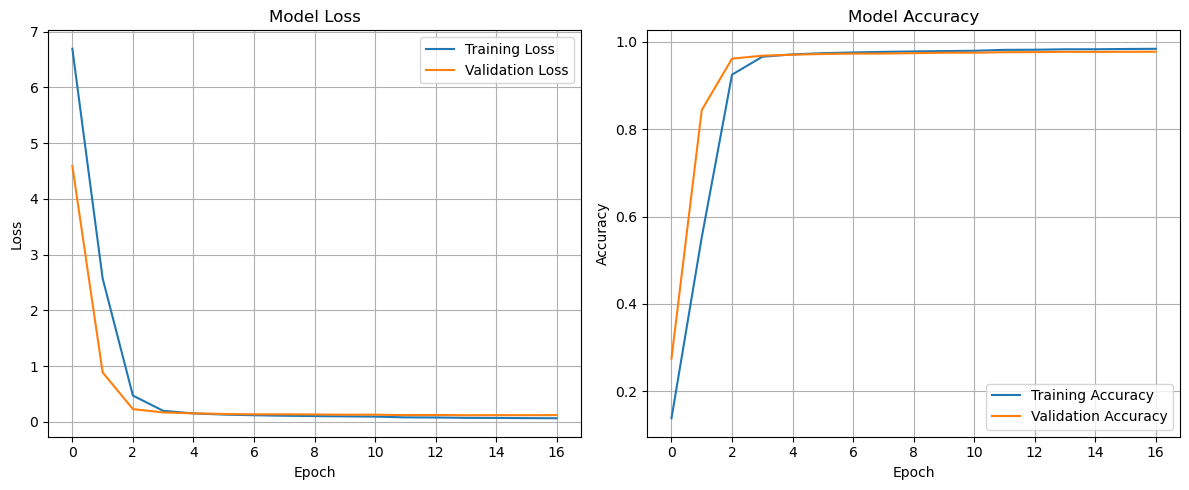

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

#### Generating text

In [40]:
def generate_text(model, sp, prompt, num_tokens=100, temperature=1.0):
    """Generate text based on a prompt with proper lowercase handling."""
    # Convert prompt to lowercase to match training data
    lowercase_prompt = prompt#.lower()

    # Encode the prompt
    input_ids = sp.encode_as_ids(lowercase_prompt)

    # Rest of your generation code stays the same...
    if len(input_ids) < seq_length:
        padding_length = seq_length - len(input_ids)
        input_ids = [0] * padding_length + input_ids
    else:
        padding_length = 0
        input_ids = input_ids[-seq_length:]

    # Generated tokens
    generated_ids = list(input_ids[padding_length:])

    # Generate text token by token
    for _ in range(num_tokens):
        x = np.array([input_ids])
        predictions = model.predict(x, verbose=0)[0]
        logits = predictions[-1]
        logits = logits / temperature
        exp_logits = np.exp(logits - np.max(logits))
        probs = exp_logits / np.sum(exp_logits)
        next_token = np.random.choice(len(probs), p=probs)
        generated_ids.append(next_token)
        input_ids = input_ids[1:] + [next_token]

    # Decode the generated sequence
    generated_text = sp.decode(generated_ids)

    return generated_text

#### Generating text

In [41]:
prompts = [
    "Viidakon kuningas Tarzan",
    "Metsän syvyyksistä",
    "Viidakon kutsu",
]

for prompt in prompts:
    print(f"\nPrompt: {prompt}")
    generated = generate_text(model, sp, prompt)
    print(generated)


Prompt: Viidakon kuningas Tarzan
Viidakon kuningas Tarzan välimatkaa aina samana. Hän ei yrittänyt selittää pitemmältä, sillä hänestä tuntui aina, että naisen täytyi inhoten katsella sellaista, joka vielä oli niin lähellä eläintä. Yhdessä he jatkoivat matkaansa. Aurinko oli tunti sitten noussut, kun he jälleen saapuivat erämaahan vuorten takana. Pienen puron varrelta he löysivät tytön hevoset syömästä. Ne olivat kotimatkallaan tulleet sinne asti ja pysähtyneet syömään ruohoa, kun niiden pelonaihe ei enää ollut saapuvilla. Vähällä vaivalla Tarzan ja tyttö ottivat ne kiinni ja nousten niiden selkään ratsastivat ulos erämaahan sheikki Kadur ben Sadenin duarille päin. He eivät

Prompt: Metsän syvyyksistä
Metsän syvyyksistä. Se ei näkynyt olevan yhtä rehellistä jokaista kohtaan. Jotta kolme meistä jäisi henkiin, täytyy yhden joukostamme kuolla ehkä muutamaa tuntia aikaisemmin kuin muutoin." Sitten hän alkoi valmistella kuoleman arvontaa, Jane Porterin istuessa silmät avoinna ja kauhuissaan

#### Uuden session aloitus

Jos aloitat uuden session, lataa seuraavat tiedostot tähän projektikansioon:
- tarzan_best_model.keras (koulutettu malli)
- tarzan_sp.model (tokenisaattori malli)

Varmista myös, että **`generate_text`**-funktio on suoritettu aiemmin.

In [ ]:
# Uncomment these lines to load a previously saved model
"""
# Load saved model
model = keras.models.load_model('tarzan_best_model.keras')

# Load SentencePiece tokenizer
sp = spm.SentencePieceProcessor()
sp.load('tarzan_sp.model')

# Make sure the generate_text function is defined

# Test generation
prompt = "Tarzan ja apina"
generated = generate_text(model, sp, prompt, num_tokens=150, temperature=1.0)
print(generated)
"""